Reference paper (not my work) - https://arxiv.org/abs/1901.11103
RNN to learn the potential to density mapping

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [3]:
potentials_dict = np.load('./Potentials.npz')
densities_dict = np.load('./Densities.npz')

In [4]:
potentials = potentials_dict['arr_0']
densities = densities_dict['arr_0']

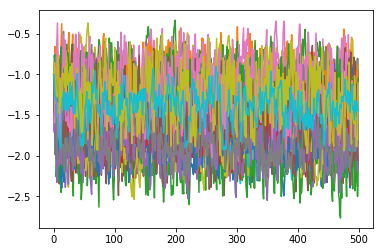

In [5]:
for i in range(len(potentials)):
    plt.plot(potentials[i])

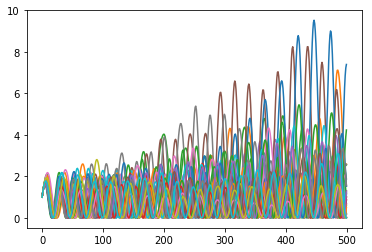

In [781]:
for i in range(len(densities)):
    plt.plot(densities[i])

In [6]:
seq_len = 15
order = 4
hidden_dim = 4
class IntroRNN(nn.Module):
    
    def __init__(self, order, hidden_dim):
        super(IntroRNN, self).__init__()
        
model = nn.RNN(input_size = 1, hidden_size = hidden_dim, num_layers = 1, batch_first = True)
list(model.parameters())

[Parameter containing:
 tensor([[0.4552],
         [0.0413],
         [0.4102],
         [0.0546]], requires_grad=True), Parameter containing:
 tensor([[-0.3949,  0.4489,  0.2736,  0.1547],
         [ 0.3381,  0.0270,  0.2413,  0.1001],
         [-0.0624,  0.3631, -0.3601,  0.2821],
         [ 0.3665, -0.0355, -0.3698, -0.4501]], requires_grad=True), Parameter containing:
 tensor([-0.0940,  0.3150,  0.3994,  0.4684], requires_grad=True), Parameter containing:
 tensor([ 0.2519, -0.2485, -0.0670,  0.3953], requires_grad=True)]

In [17]:
x = torch.tensor(potentials[0][:seq_len], dtype = torch.float)
x = torch.unsqueeze(x, dim = 0)
x = torch.unsqueeze(x, dim = 2)
y = torch.tensor(densities[0][:seq_len], dtype = torch.float)
y = torch.unsqueeze(y, dim = 0)
y = torch.unsqueeze(y, dim = 2)

In [18]:
x.shape

torch.Size([1, 15, 1])

In [19]:
y.shape

torch.Size([1, 15, 1])

In [28]:
criterion = nn.MSELoss()
ypreds, h = model(x)
print(ypred.shape, h.shape)
loss = criterion(torch.squeeze(ypreds[:, :, -1]), torch.squeeze(y))
print(loss)
rnn.zero_grad()
loss.backward()
print(rnn.W.grad)
print(rnn.p.grad)

torch.Size([1, 15, 4]) torch.Size([1, 1, 4])


RuntimeError: The size of tensor a (4) must match the size of tensor b (15) at non-singleton dimension 1

In [786]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [787]:
device

device(type='cuda', index=0)

In [788]:
n_seq = len(potentials)
seq_len = len(potentials[0])
n_train = 20

In [789]:
X_train = np.array([potentials[i][j*n_steps:(j + 1)*n_steps] for i in range(n_train) for j in range(1, seq_len//n_steps)])
X_train.shape

(640, 15)

In [790]:
y_train = np.array([densities[i][j*n_steps:(j + 1)*n_steps] for i in range(n_train) for j in range(1, seq_len//n_steps)])
y_train.shape

(640, 15)

In [791]:
# Xy = np.hstack((X_train, y_train))
# print(Xy.shape)
# np.random.shuffle(Xy)
# X_train = Xy[:, :X_train.shape[1]]
# y_train = Xy[:, X_train.shape[1]:]

In [792]:
X_train.shape

(640, 15)

In [793]:
y_train.shape

(640, 15)

In [794]:
model = IntroRNN(n_steps, order, hidden_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()
loss_vals = []

In [ ]:
epochs = 15
avg_loss = 0
for e in range(epochs):
    avg_loss = 0
    for i in range(len(X_train)):
        data = torch.unsqueeze(torch.as_tensor(X_train[i], dtype = torch.float), dim = 1)
        data = data.to(device)
        target = torch.unsqueeze(torch.as_tensor(y_train[i], dtype = torch.float), dim = 1)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss_vals.append(loss.item())
        avg_loss += loss_vals[-1]
        loss.backward(retain_graph = True)
        optimizer.step()
#         if i % 2 == 0:
        model.init_hidden()
    avg_loss /= len(X_train)
    print('Epoch = {}, avg. loss = {:.3}'.format(e, avg_loss))

Epoch = 0, avg. loss = 7.04e+11
Epoch = 1, avg. loss = 5.03e+11
Epoch = 2, avg. loss = 3.58e+11
Epoch = 3, avg. loss = 2.55e+11
Epoch = 4, avg. loss = 1.81e+11


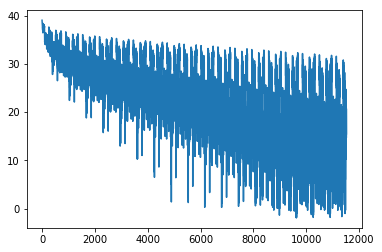

In [804]:
plt.plot(np.log(np.array(loss_vals)))

In [797]:
loss_vals[-10:-1]

[71205239390208.0,
 33900871024640.0,
 101121003618304.0,
 4910641315840.0,
 57940358725632.0,
 5433041354752.0,
 3177706160128.0,
 32803815161856.0,
 14188902612992.0]

In [798]:
out

tensor([2.4885e+00, 7.9581e+00, 2.3878e+01, 7.1679e+01, 2.0047e+02, 5.6828e+02,
        1.4771e+03, 4.4112e+03, 1.2733e+04, 3.9558e+04, 1.2525e+05, 3.7546e+05,
        1.0849e+06, 2.8559e+06, 7.4053e+06], grad_fn=<CopySlices>)

In [799]:
target

tensor([[1.2409],
        [1.7399],
        [2.2625],
        [2.7721],
        [3.2307],
        [3.6023],
        [3.8551],
        [3.9758],
        [3.9647],
        [3.8270],
        [3.5815],
        [3.2389],
        [2.8121],
        [2.3221],
        [1.7992]])

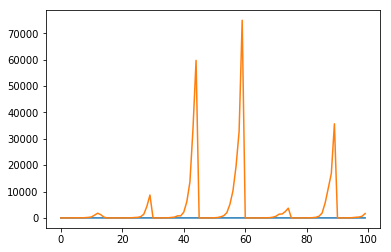

In [805]:
i = 4
y = densities[i]
X_test = [potentials[i][j*n_steps:(j + 1)*n_steps] for j in range(seq_len//n_steps)]
yh = []
for i in range(len(X_test)):
    data = torch.unsqueeze(torch.as_tensor(X_test[i], dtype = torch.float), dim = 1)
    data = data.to(device)
    out = model(data)
    yh.extend(out.detach().numpy())
    model.init_hidden()

plt.figure()
plt.plot(y[:100])
plt.plot(np.array(yh)[:100])

In [801]:
model.W

Parameter containing:
tensor([[[ 0.9528,  0.9562,  0.9531,  0.9525],
         [ 0.9552,  0.9546,  0.9517,  0.9497],
         [ 0.9643,  0.9567,  0.9490,  0.9584],
         [ 0.9603,  0.9571,  0.9574,  0.9545]],

        [[ 0.0347,  0.0339,  0.0362,  0.0321],
         [ 0.0358,  0.0329,  0.0351,  0.0309],
         [ 0.0350,  0.0364,  0.0374,  0.0370],
         [ 0.0357,  0.0355,  0.0350,  0.0328]],

        [[-0.0280, -0.0298, -0.0248, -0.0227],
         [-0.0250, -0.0220, -0.0250, -0.0232],
         [-0.0248, -0.0257, -0.0257, -0.0287],
         [-0.0255, -0.0314, -0.0317, -0.0274]],

        [[ 0.0205,  0.0175,  0.0198,  0.0176],
         [ 0.0217,  0.0181,  0.0187,  0.0160],
         [ 0.0181,  0.0210,  0.0245,  0.0167],
         [ 0.0220,  0.0162,  0.0183,  0.0169]]], device='cuda:0',
       requires_grad=True)

In [802]:
model.p

Parameter containing:
tensor([ 0.9536, -0.0464, -0.0467, -0.0467], device='cuda:0',
       requires_grad=True)